In [1]:
# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import PHILIPS2LBOTTLE, PHILIPS1L5BOTTLE, PIQTSP
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import qa_date, scanner_operator, larmor_frequency

def show_test_result(passed):
    colour, status = 'green', 'ACCEPTABLE' if passed else 'red', 'FAILED'
    return HTMLLatex(
        f'<b>Test Result - <span style="color:{colour}">{status}</span></b>',
        f'\\textbf{{Test Result -- \\color{{{colour}}}{status}}}'
    )


# Watermark
wm = watermark()
display(pd.DataFrame(
    {'Watermark': list(wm.values())},
    index=wm.keys()
))

Watermark
CalculationTime  2022-04-04T16:28:31+01:00
User                        birchhub/rtrhd
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.11
dcmextras                            0.2.6
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

# Summary
Tests Performed:

- Slice shape and Profile
- Distortion and Field of View
- Resolution
- Ghosting
- Head Coil Image Uniformity
- Head Coil SNR

----

All of the above are acceptable.

----

### Details of series to analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid
series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')

display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner     HOST-9THVNMQAOJ
Date               20200121
Patient  AQA20200121NBTMR21
Study             632565636

In [3]:
text = f'''
{operator}
Medical Physics & Bioengineering, UH Bristol
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))

In [4]:
NewPage

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo using the crossed _slice profile_ slots in the PIQT phantom.

### 3 mm Slice

In [5]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobj = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
results = slice_profile_report(dobj, frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

In [6]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slice_isx = info['Series']['5mm'], info['Slice']['5mm']

dobj = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
result = slice_profile_report(dobj, frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [7]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                55.7             2.8
5.0                                92.4             4.7

These profile widths are well within the AAPM tolerance of 0.5mm.

In [8]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are before and after applying Philips 2D distortion correction.

In [9]:
# PIQT: Distortion : SE Axial, Phase RL, 512 matrix (Uncorrected)
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

seriesno, frame = series['AxialRL_Uncorrected'], slices['AxialRL_Uncorrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = piqt_distortion_report(dobj, frame=frame)

In [10]:
# PIQT: Distortion : SE Axial, Phase AP, 512 matrix (Uncorrected)
seriesno, frame = series['AxialAP_Uncorrected'], slices['AxialAP_Uncorrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = results.append(piqt_distortion_report(dobj, frame=frame))

In [11]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
703          Axial              RL        0.152                149.927   
603          Axial              AP        0.152                150.216   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
703                     0.048              149.331                0.055  
603                     0.099              149.068                0.070

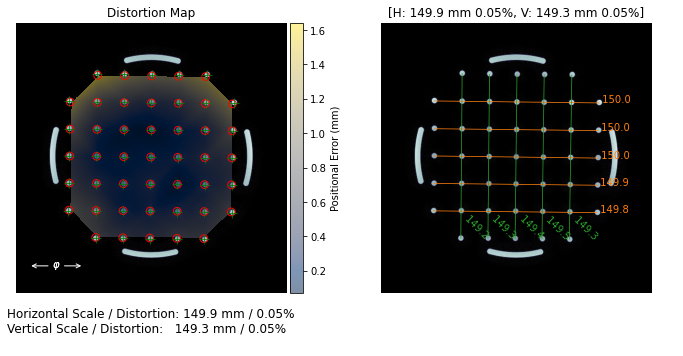

In [12]:
# PIQT: Distortion : SE Axial, Phase RL, 512 matrix (Corrected)
seriesno, frame = series['AxialRL_Corrected'], slices['AxialRL_Corrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = piqt_distortion_report(dobj, frame=frame)

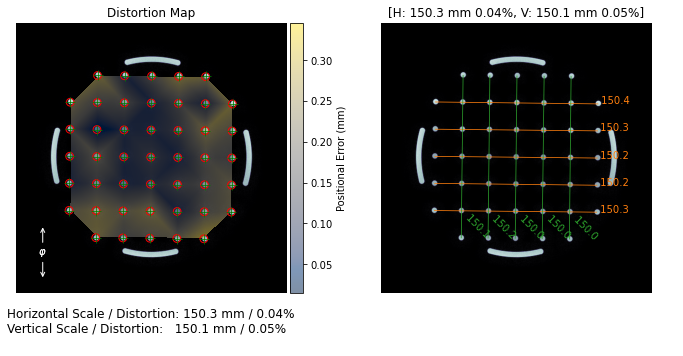

In [13]:
# PIQT: Distortion : SE Axial, Phase AP, 512 matrix (Corrected)
seriesno, frame = series['AxialAP_Corrected'], slices['AxialAP_Corrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = results.append(piqt_distortion_report(dobj, frame=frame))

In [14]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
703          Axial              RL        0.152                149.927   
604          Axial              AP        0.152                150.270   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
703                     0.048              149.331                0.055  
604                     0.039              150.079                0.046

The scale in both the RL and AP directions are well within 1% at the bandwidth used (130Hz/pixel).

In [15]:
NewPage

## Resolution

Image resolution is estimated by analysis of the MTF block in the PIQT phantom.

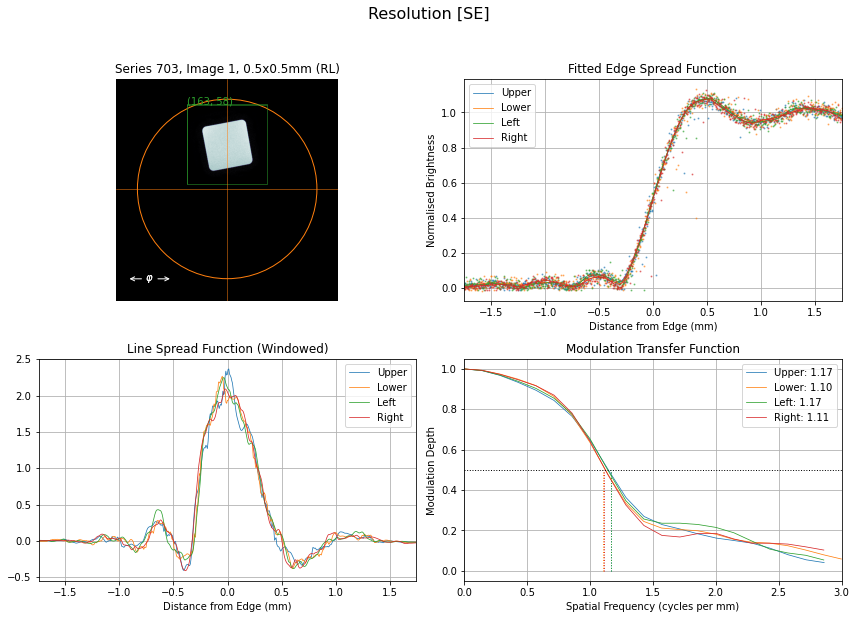

MTF_50
Upper   1.168
Lower   1.101
Left    1.167
Right   1.108

In [16]:
# PIQT: Resolution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
# no 512 acquisition, using 256
dobjs = sorted(fetch_series(patid, studyid, sernos=[series['SE512']], imagesonly=True), key=lambda d: int(d.InstanceNumber))
if len(dobjs) > 1: #accommodate multiframes
    dobj_mtf, dobj_centre = dobjs[slices['MTF']], dobjs[slices['Centre']]
    results = mtf_report(dobj_mtf, dobj_centre)
else:
    results = mtf_report(dobjs[0], mtf_frame=slices['MTF'], centring_frame=slices['Centre'])
plt.show()
results

The MTF_50 is consistent with an image resolution of 0.5 x 0.5 mm as is the case here with a `512*512` acquisition.

In [17]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

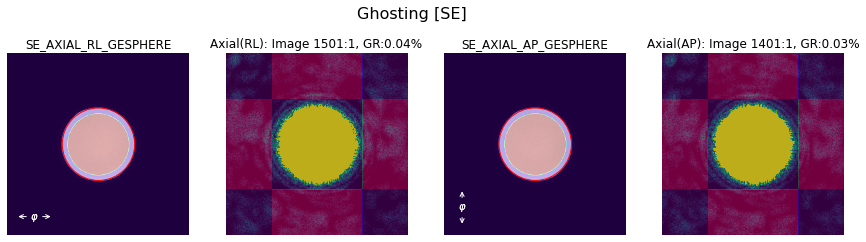

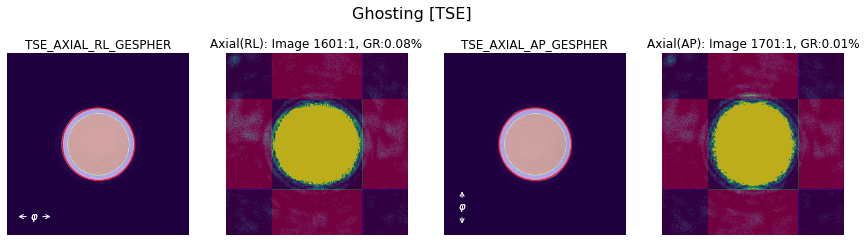

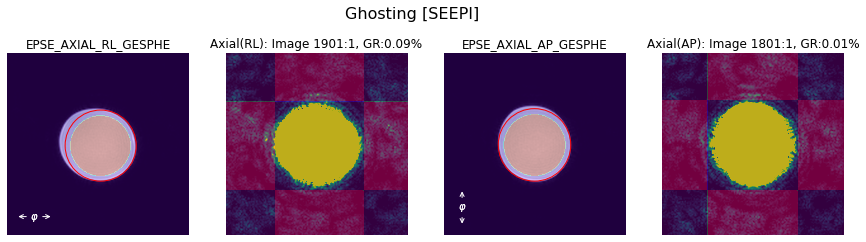

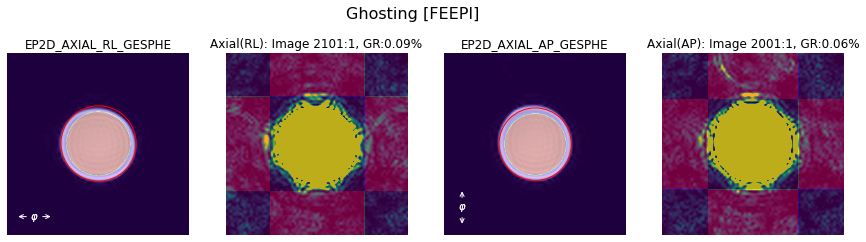

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                      
1501         SE       Axial              RL            0.042
1401         SE       Axial              AP            0.028
1601        TSE       Axial              RL            0.079
1701        TSE       Axial              AP            0.015
1901      SEEPI       Axial              RL            0.091
1801      SEEPI       Axial              AP            0.011
2101      FEEPI       Axial              RL            0.092
2001      FEEPI       Axial              AP            0.059

In [18]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is under 1% for all sequences measured here including the EPIs.

In [19]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the 20 Channel head coil using a spherical phantom filled with silicone oil. Results are presented both before and after `CLEAR` intensity correction.

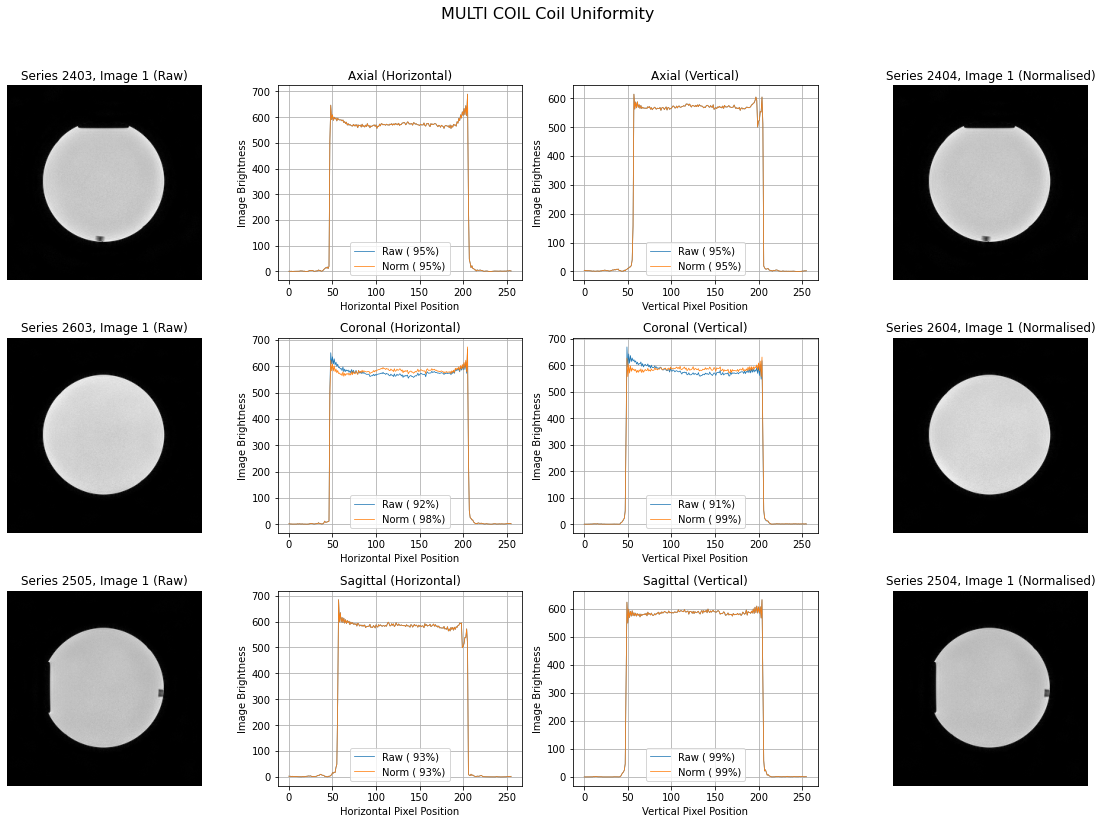

Raw Images


Series No.                      Protocol         Axis  \
Orientation                                                          
Axial              2403  SE_AXIAL_RL_UNIF_OIL_NONUNIF     Axial/RL   
Coronal            2603    SE_COR_RL_UNIF_OIL_NONUNIF   Coronal/RL   
Sagittal           2505    SE_SAG_AP_UNIF_OIL_NONUNIF  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    95.00             94.67  
Coronal                  92.50             91.14  
Sagittal                 92.67             98.73

Intensity Normalised Images


Series No.                    Protocol         Axis  \
Orientation                                                        
Axial              2404  SE_AXIAL_RL_UNIF_OIL_CLEAR     Axial/RL   
Coronal            2604    SE_COR_RL_UNIF_OIL_CLEAR   Coronal/RL   
Sagittal           2504    SE_SAG_AP_UNIF_OIL_CLEAR  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    95.00             94.67  
Coronal                  98.12             98.73  
Sagittal                 92.67             98.73

In [20]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0], imagesonly=True)
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1], imagesonly=True)
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0], imagesonly=True)
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1], imagesonly=True)
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0], imagesonly=True)
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1], imagesonly=True)

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

The images are very uniform for a multielement coil. It appears that a `CLEAR` or similar uniformity correction has been applied to both image sets so it is not clear how non-uniform the receive field is without this correction.

In [21]:
NewPage

## Signal to Noise

For reference purposes the following is an independent estimate for the standard head/neck coil using the Philips 2L bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

### 20 Channel Head Coil

#### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is also the methodology used in the quarterly QA.

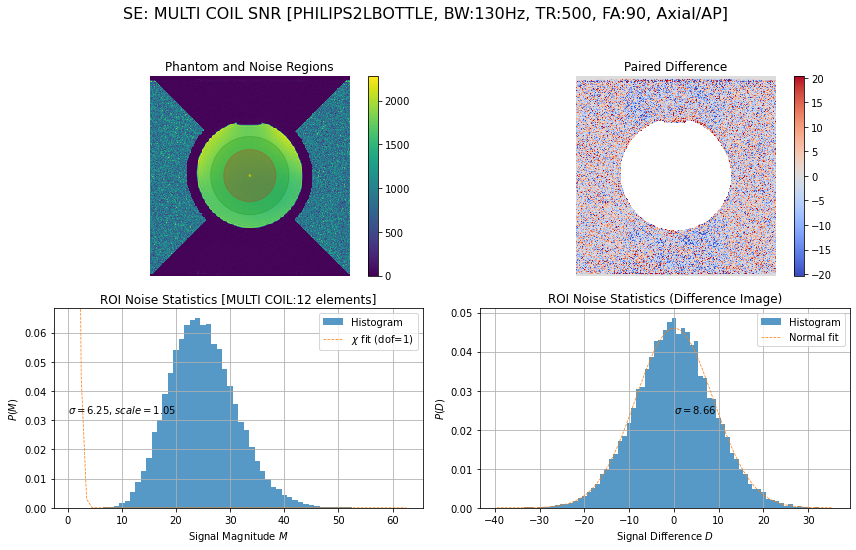

MULTI COIL
0.50      267.82
0.75      272.33

In [22]:
# SNR (uncombined channels)
info = tests['QuarterlySNR_20']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

dobjs = fetch_series(patid, stuid, series['Signal'], imagesonly=True)
assert len(dobjs) == 1, f'{len(dobjs)}'
results = snr_report_multi(dobjs, phantom=PHILIPS2LBOTTLE)
plt.show()

with pd.option_context('display.precision', 2):
    display(results)

SNR values are acceptable and there are no significant artefacts. Note, however, that only 12 of the 20 elements are present and the fit to the expected non-central $\chi$ distribution failed. It is possible that coil channel reduction was applied that changed the statistics.

In [23]:
NewPage

### Frequency Reference
This is the reference value reported in the DICOM header of a localizer scan.

In [24]:
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series)[0]
pd.DataFrame({
    'ImagingFrequency': [larmor_frequency(dobj)]
}, index=['Value']).T

Value
ImagingFrequency  63.889